UPDATE: dt = 0.0014641016151377547 and dx = 0.04


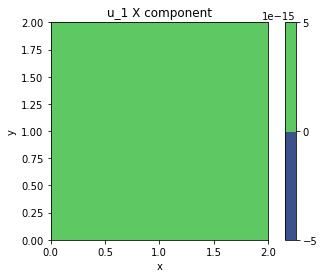

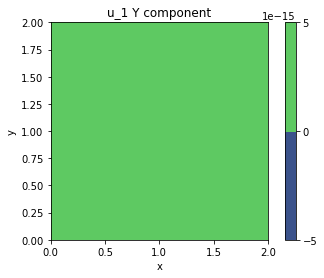

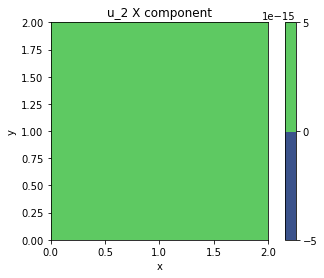

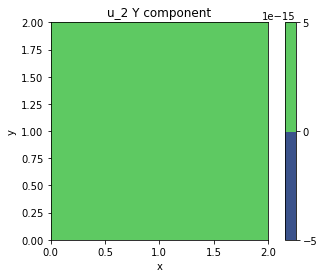

writing at t = 0.0029282032302755095


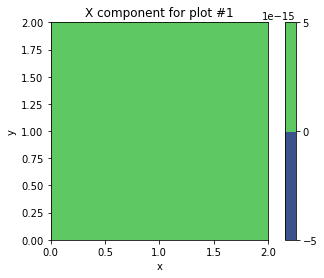

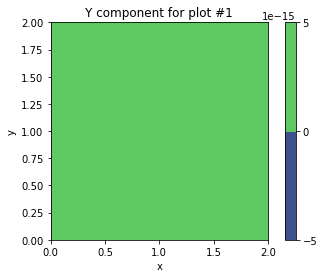

2.7206990463513265
solving at time step t=0.0029282
Calling FFC just-in-time (JIT) compiler, this may take some time.
writing at t = 0.004392304845413264


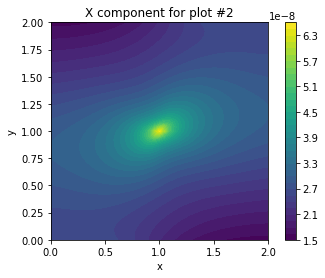

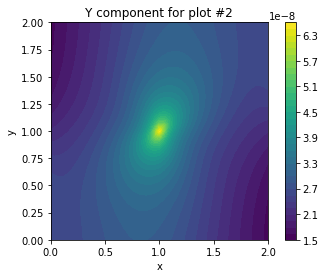

2.7206990463513265
solving at time step t=0.0043923
writing at t = 0.005856406460551019


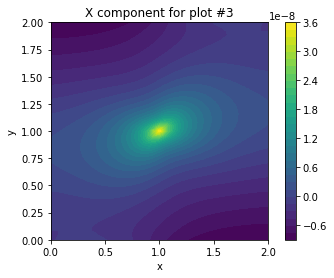

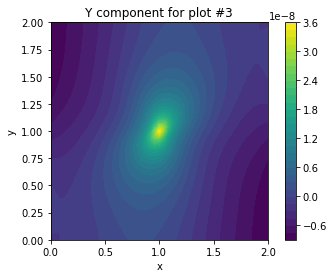

2.7206990463513265
solving at time step t=0.00585641
writing at t = 0.007320508075688774


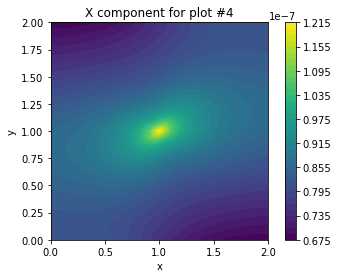

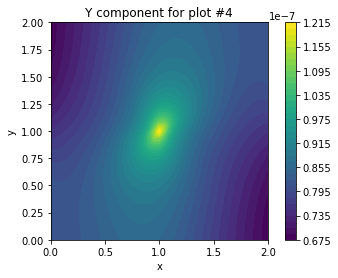

2.7206990463513265
solving at time step t=0.00732051
writing at t = 0.008784609690826528


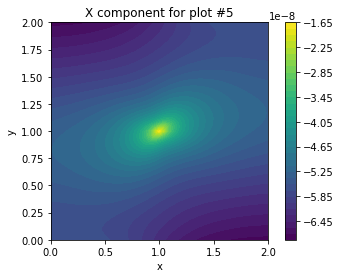

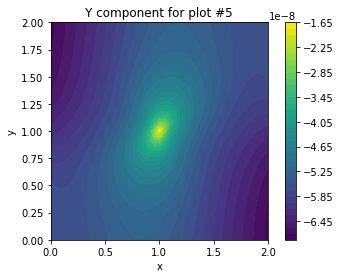

2.7206990463513265
solving at time step t=0.00878461
writing at t = 0.010248711305964282


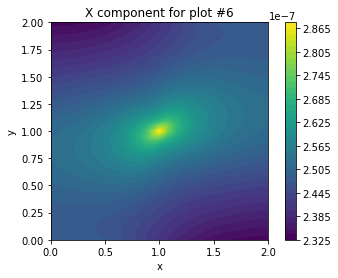

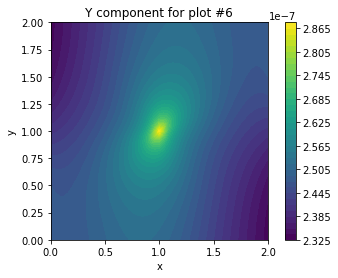

2.7206990463513265
solving at time step t=0.0102487
writing at t = 0.011712812921102038


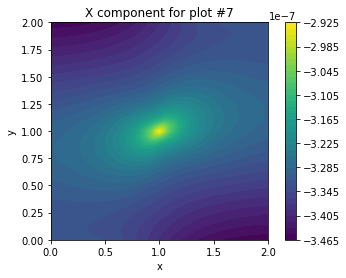

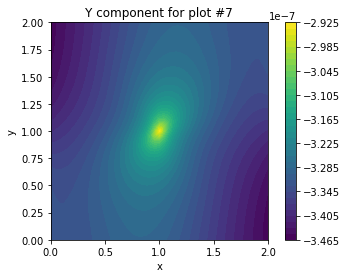

2.7206990463513265
solving at time step t=0.0117128
writing at t = 0.013176914536239794


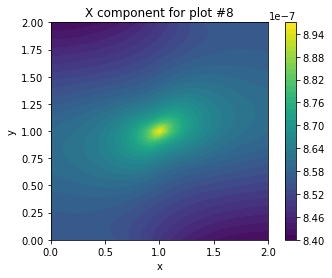

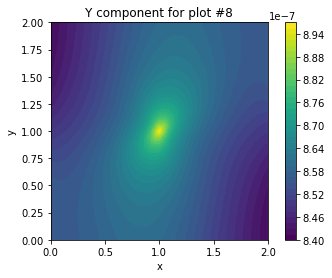

2.7206990463513265
solving at time step t=0.0131769
writing at t = 0.01464101615137755


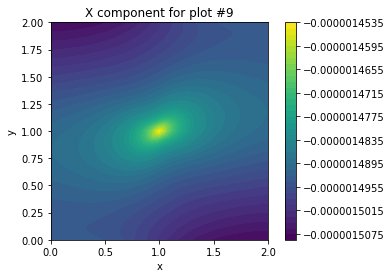

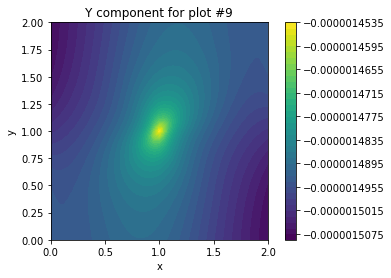

2.7206990463513265
solving at time step t=0.014641
writing at t = 0.016105117766515305


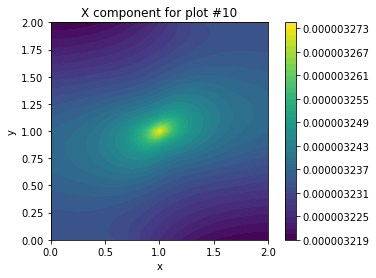

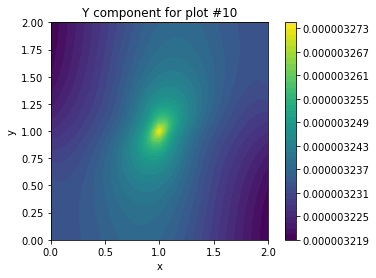

2.7206990463513265
solving at time step t=0.0161051
writing at t = 0.01756921938165306


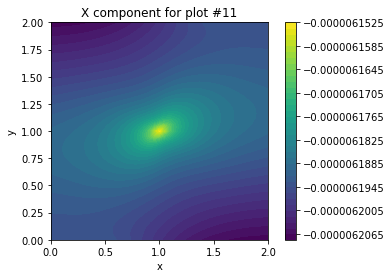

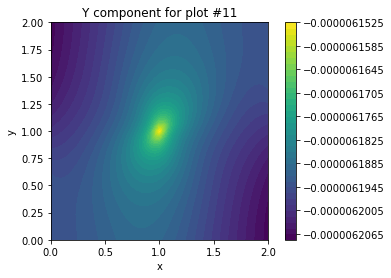

2.7206990463513265
solving at time step t=0.0175692
writing at t = 0.019033320996790816


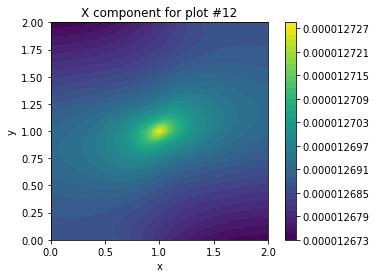

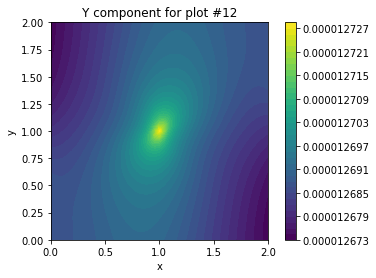

2.7206990463513265
solving at time step t=0.0190333
writing at t = 0.02049742261192857


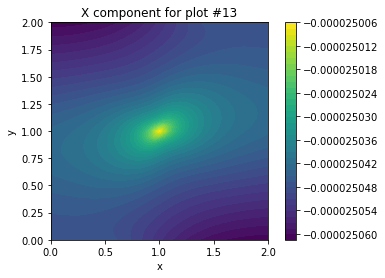

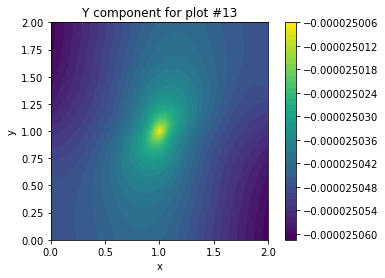

2.7206990463513265
solving at time step t=0.0204974
writing at t = 0.021961524227066327


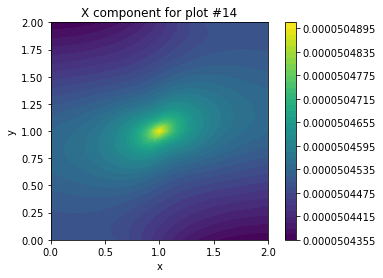

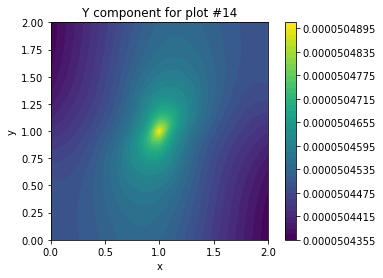

2.7206990463513265
solving at time step t=0.0219615
writing at t = 0.023425625842204083


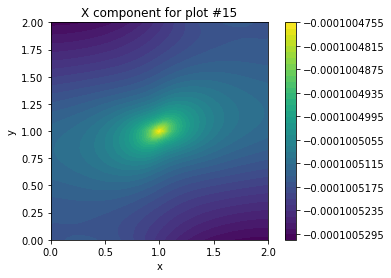

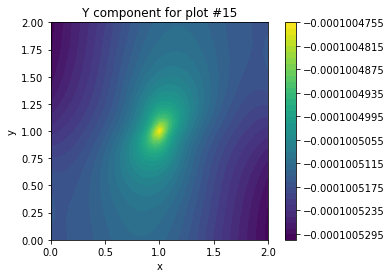

2.7206990463513265
solving at time step t=0.0234256
writing at t = 0.02488972745734184


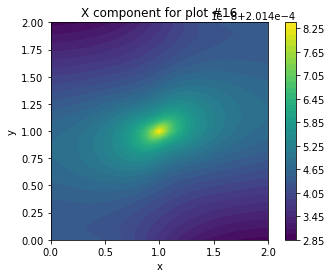

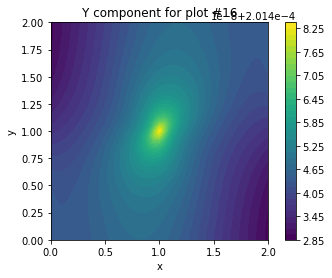

2.7206990463513265
solving at time step t=0.0248897
writing at t = 0.026353829072479594


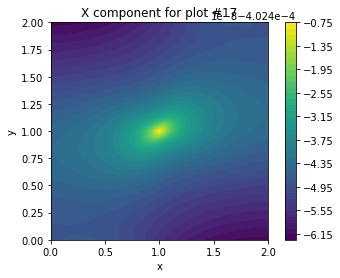

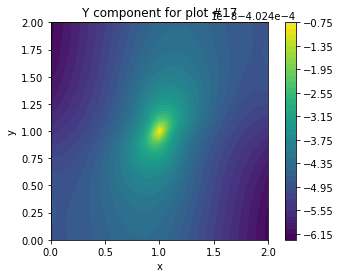

2.7206990463513265
solving at time step t=0.0263538
writing at t = 0.02781793068761735


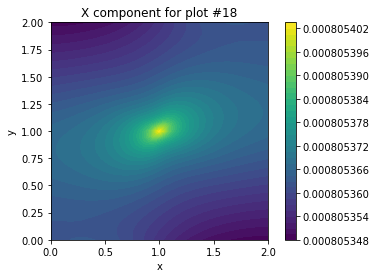

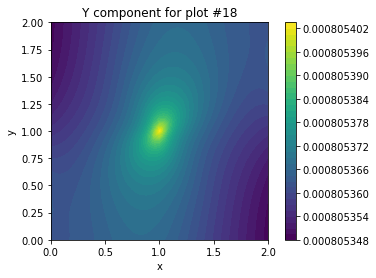

2.7206990463513265
solving at time step t=0.0278179
writing at t = 0.029282032302755105


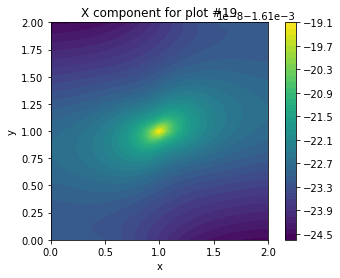

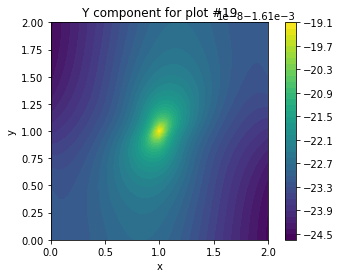

2.7206990463513265
solving at time step t=0.029282
writing at t = 0.03074613391789286


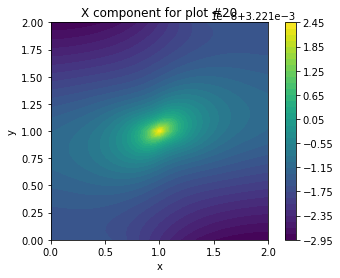

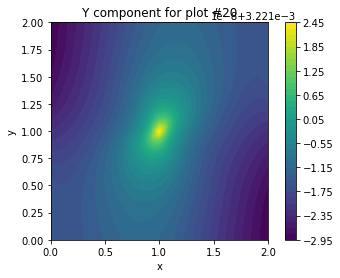

2.7206990463513265
solving at time step t=0.0307461
writing at t = 0.032210235533030616


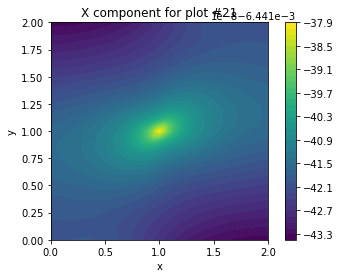

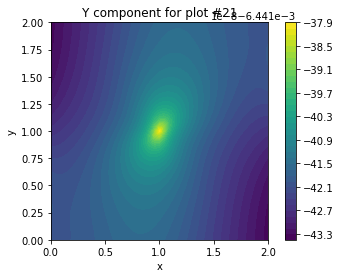

2.7206990463513265
solving at time step t=0.0322102
writing at t = 0.03367433714816837


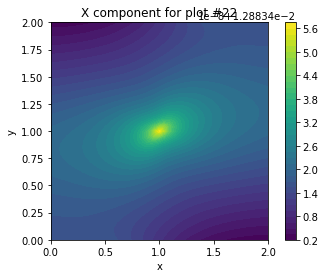

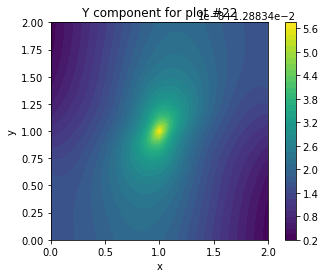

2.7206990463513265
solving at time step t=0.0336743
writing at t = 0.03513843876330613


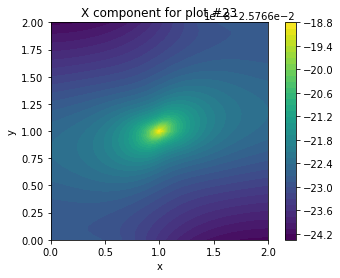

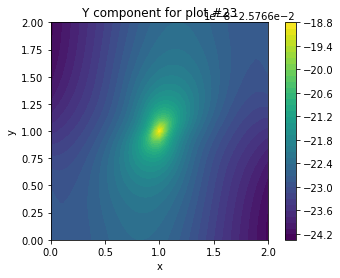

2.7206990463513265
solving at time step t=0.0351384
writing at t = 0.03660254037844388


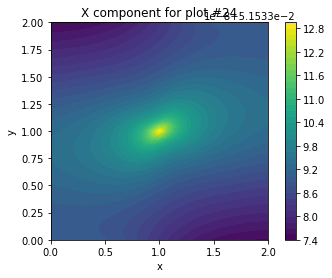

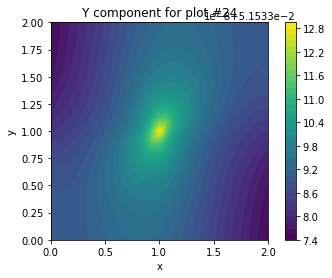

2.7206990463513265
solving at time step t=0.0366025
writing at t = 0.03806664199358164


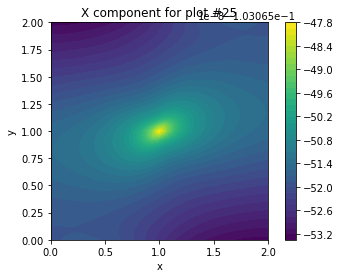

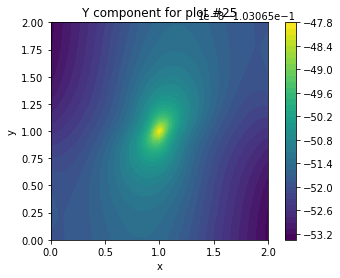

2.7206990463513265
solving at time step t=0.0380666
writing at t = 0.039530743608719394


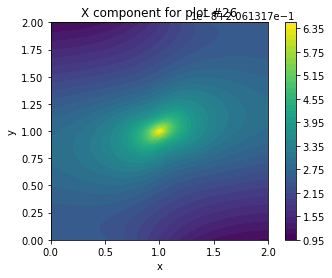

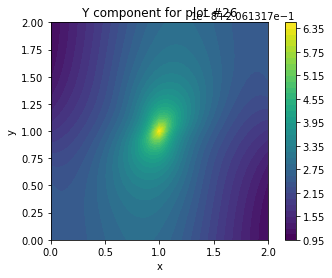

2.7206990463513265
solving at time step t=0.0395307
writing at t = 0.04099484522385715


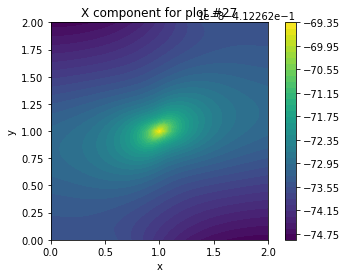

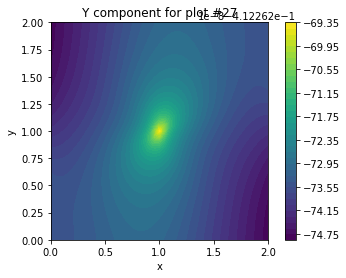

2.7206990463513265
solving at time step t=0.0409948
writing at t = 0.042458946838994906


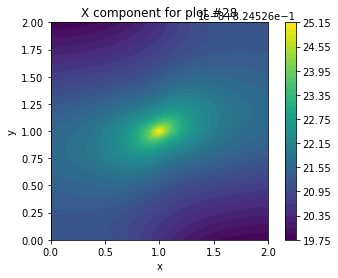

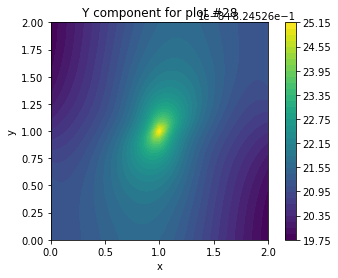

2.7206990463513265
solving at time step t=0.0424589
writing at t = 0.04392304845413266


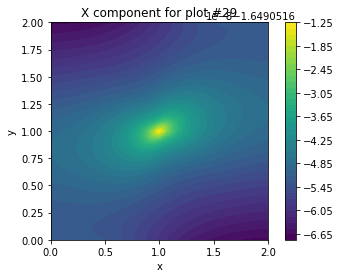

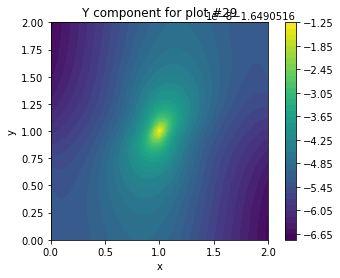

2.7206990463513265
solving at time step t=0.043923
writing at t = 0.04538715006927042


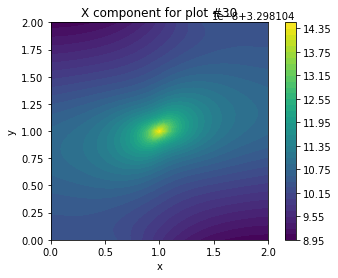

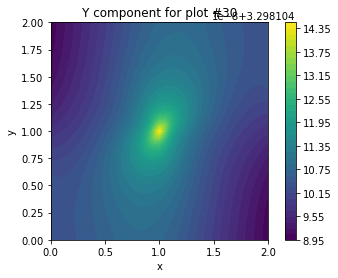

2.7206990463513265
solving at time step t=0.0453872
writing at t = 0.04685125168440817


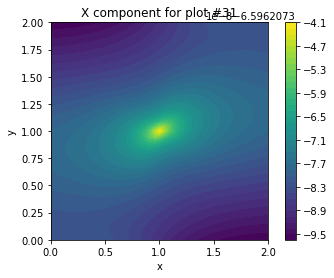

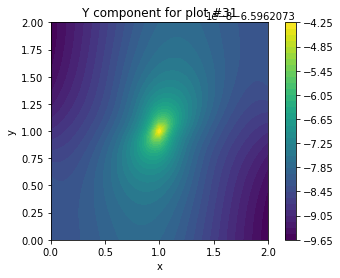

2.7206990463513265
solving at time step t=0.0468513
writing at t = 0.04831535329954593


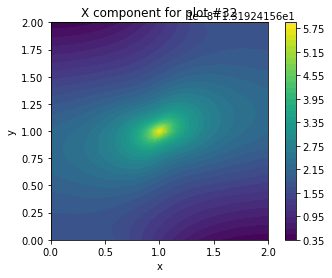

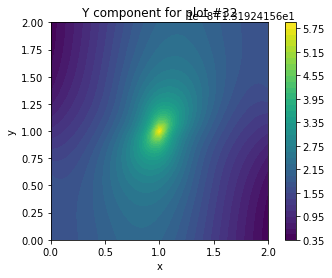

2.7206990463513265
solving at time step t=0.0483154
writing at t = 0.049779454914683684


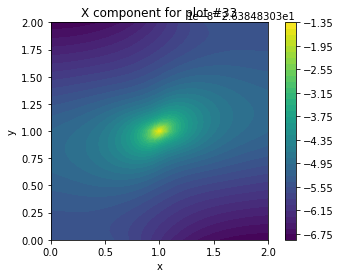

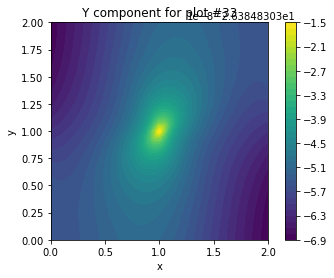

2.7206990463513265
solving at time step t=0.0497795
writing at t = 0.05124355652982144


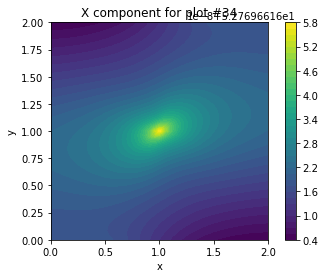

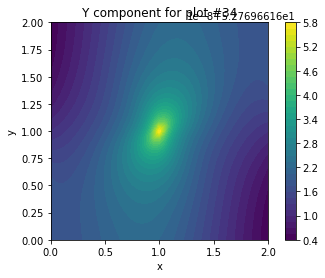

2.7206990463513265
solving at time step t=0.0512436
writing at t = 0.052707658144959195


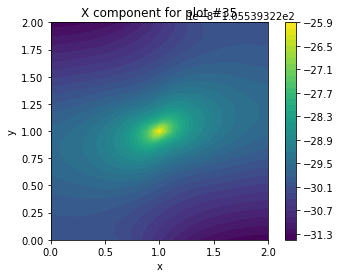

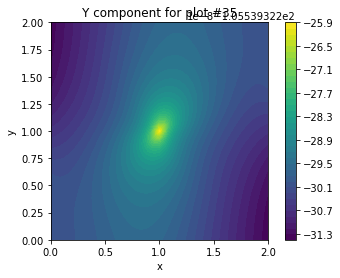

2.7206990463513265
solving at time step t=0.0527077
writing at t = 0.05417175976009695


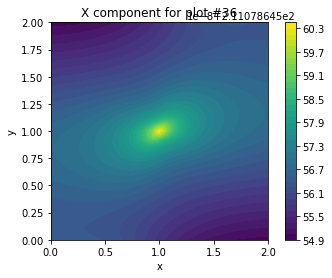

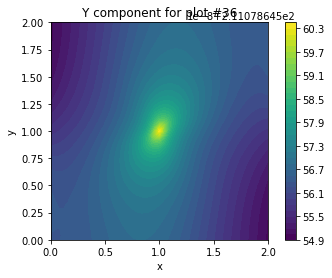

2.7206990463513265
solving at time step t=0.0541718
writing at t = 0.055635861375234706


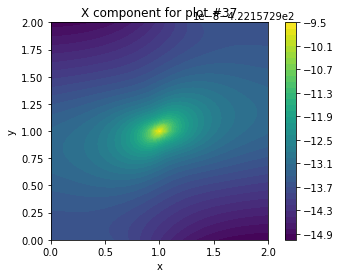

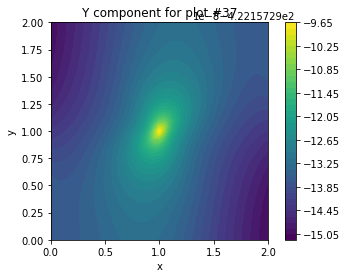

2.7206990463513265
solving at time step t=0.0556359
writing at t = 0.05709996299037246


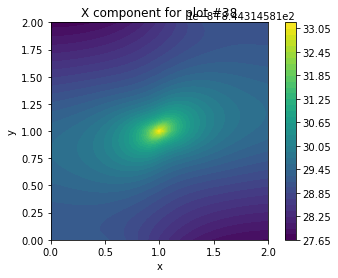

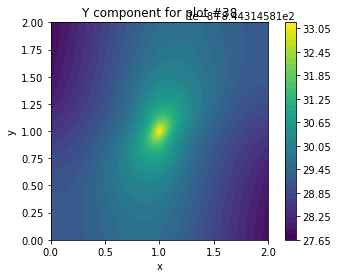

2.7206990463513265
solving at time step t=0.0571
writing at t = 0.05856406460551022


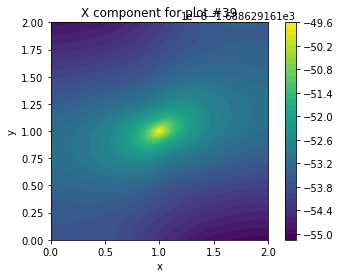

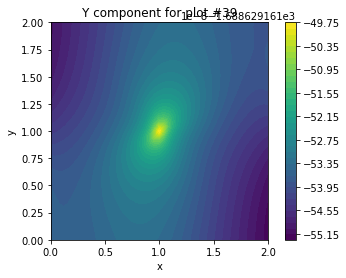

2.7206990463513265
solving at time step t=0.0585641
writing at t = 0.06002816622064797


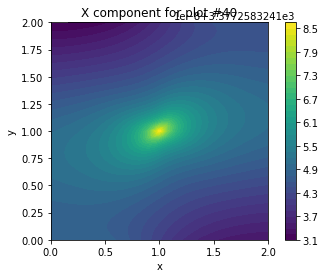

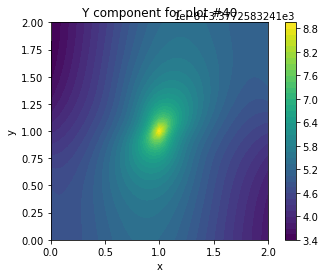

2.7206990463513265
solving at time step t=0.0600282
writing at t = 0.06149226783578573


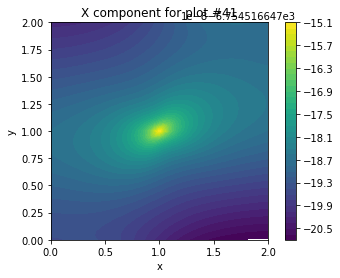

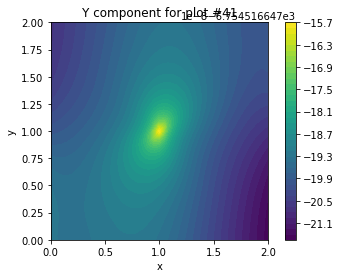

2.7206990463513265
solving at time step t=0.0614923
writing at t = 0.06295636945092348


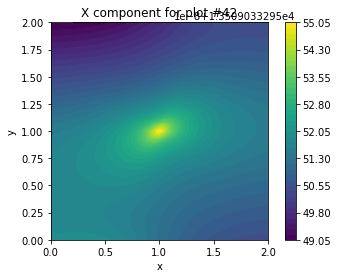

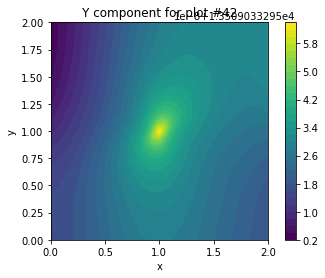

2.7206990463513265
solving at time step t=0.0629564
writing at t = 0.06442047106606123


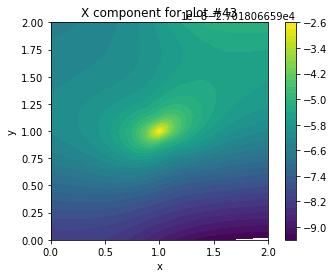

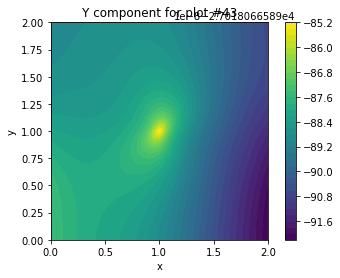

2.7206990463513265
solving at time step t=0.0644205
writing at t = 0.06588457268119899


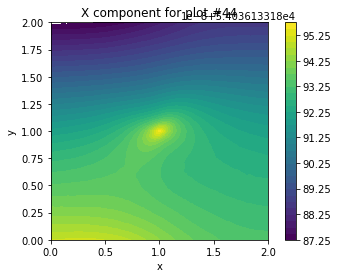

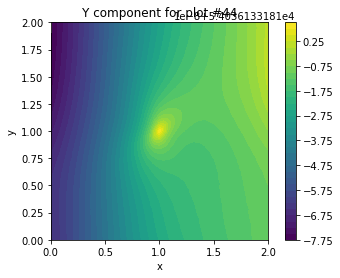

2.7206990463513265
solving at time step t=0.0658846
writing at t = 0.06734867429633674


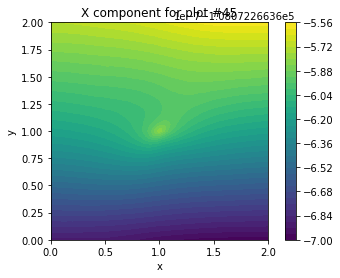

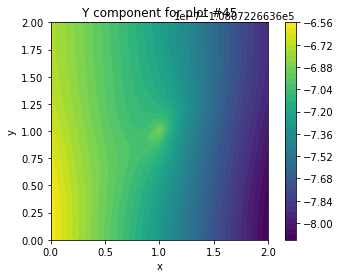

2.7206990463513265
solving at time step t=0.0673487
writing at t = 0.0688127759114745


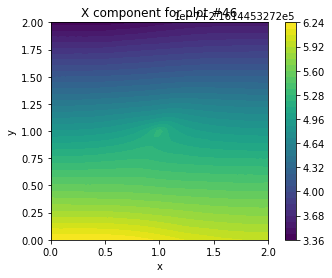

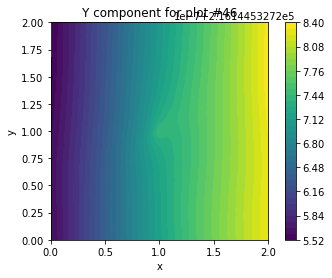

2.7206990463513265
solving at time step t=0.0688128
writing at t = 0.07027687752661226


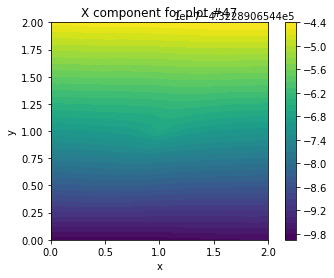

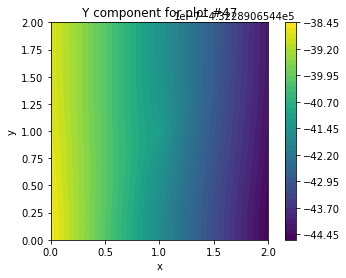

2.7206990463513265
solving at time step t=0.0702769
writing at t = 0.07174097914175001


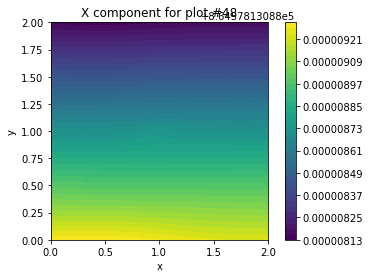

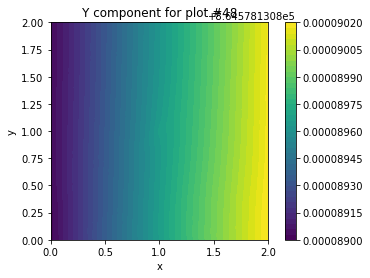

2.7206990463513265
solving at time step t=0.071741
writing at t = 0.07320508075688777


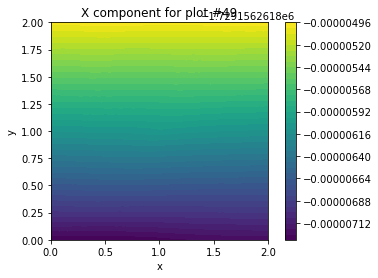

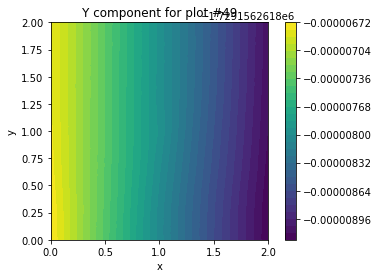

2.7206990463513265
solving at time step t=0.0732051
writing at t = 0.07466918237202552


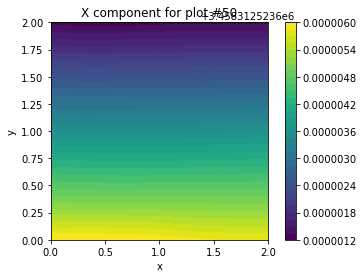

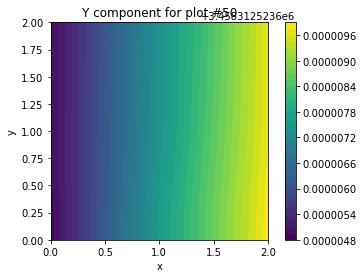

2.7206990463513265
solving at time step t=0.0746692
writing at t = 0.07613328398716328


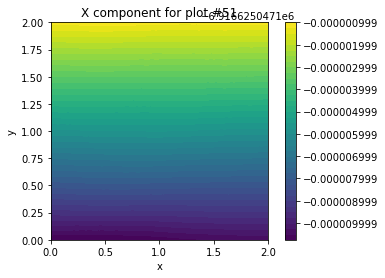

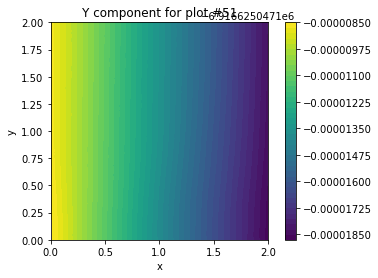

2.7206990463513265
solving at time step t=0.0761333
writing at t = 0.07759738560230103


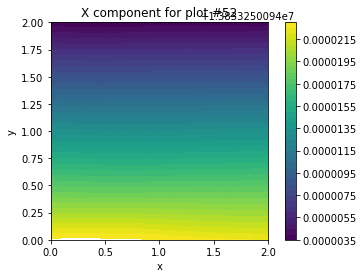

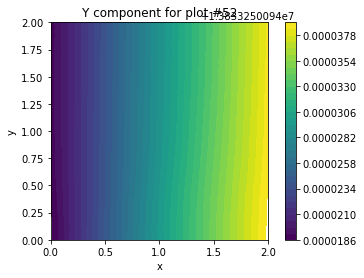

2.7206990463513265
solving at time step t=0.0775974
writing at t = 0.07906148721743879


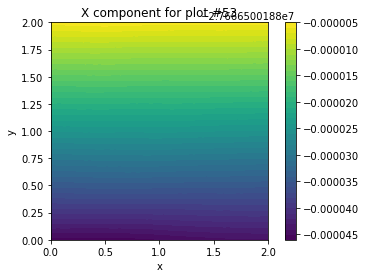

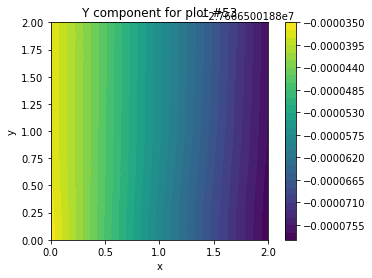

2.7206990463513265
solving at time step t=0.0790615
writing at t = 0.08052558883257654


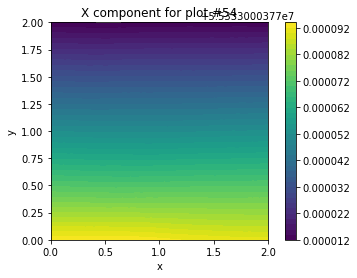

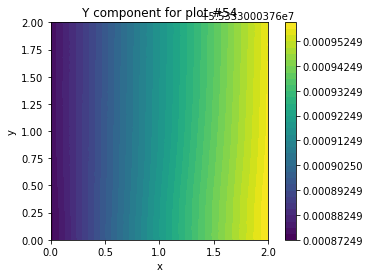

2.7206990463513265
solving at time step t=0.0805256
writing at t = 0.0819896904477143


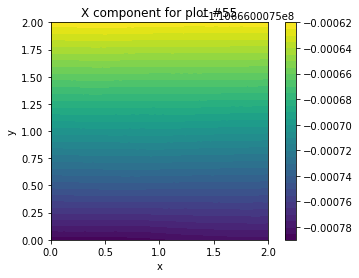

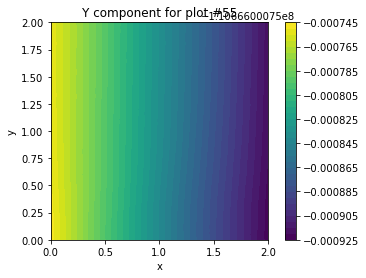

2.7206990463513265
solving at time step t=0.0819897
writing at t = 0.08345379206285206


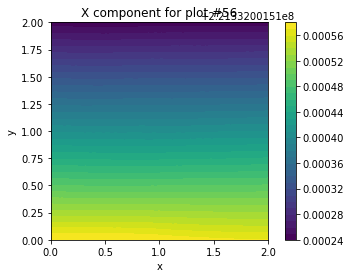

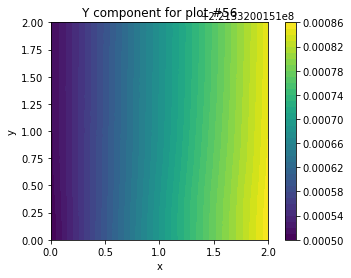

2.7206990463513265
solving at time step t=0.0834538
writing at t = 0.08491789367798981


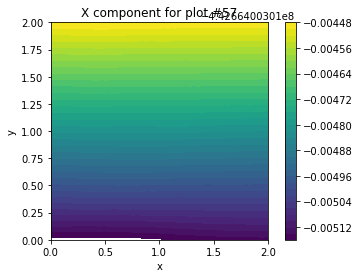

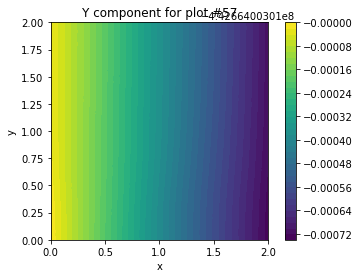

2.7206990463513265
solving at time step t=0.0849179
writing at t = 0.08638199529312757


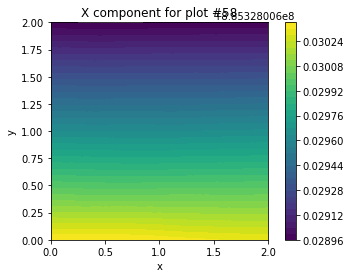

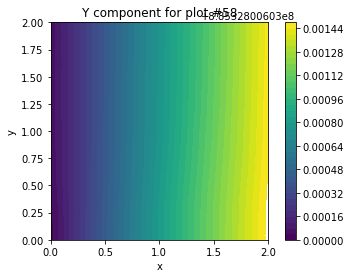

2.7206990463513265
solving at time step t=0.086382
writing at t = 0.08784609690826532


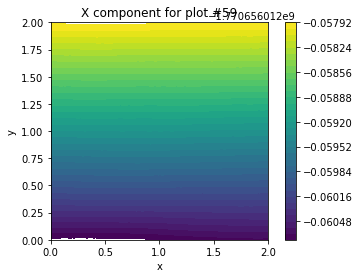

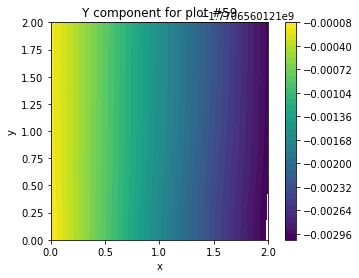

2.7206990463513265
solving at time step t=0.0878461
writing at t = 0.08931019852340308


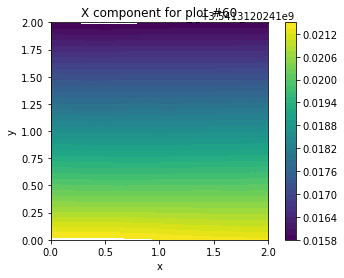

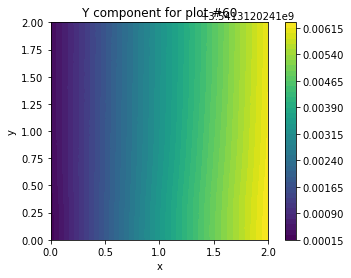

2.7206990463513265
solving at time step t=0.0893102
writing at t = 0.09077430013854083


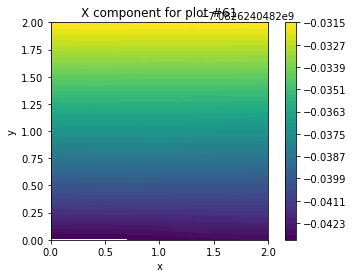

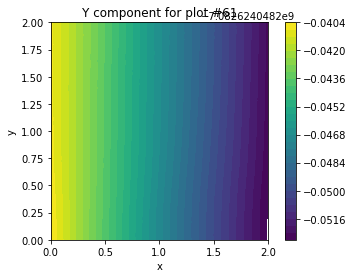

2.7206990463513265
solving at time step t=0.0907743
writing at t = 0.09223840175367859


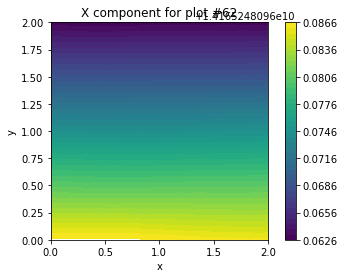

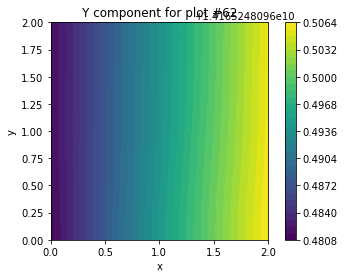

2.7206990463513265
solving at time step t=0.0922384
writing at t = 0.09370250336881635


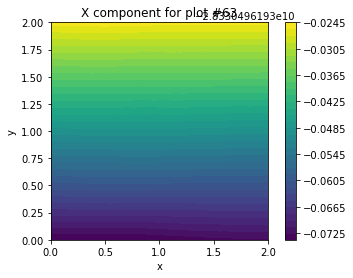

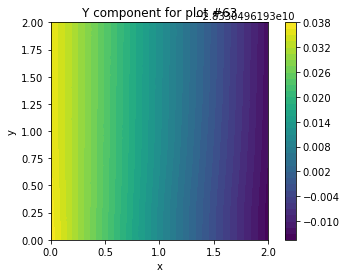

2.7206990463513265
solving at time step t=0.0937025
writing at t = 0.0951666049839541


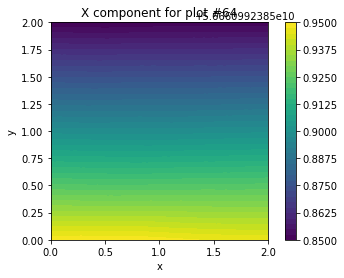

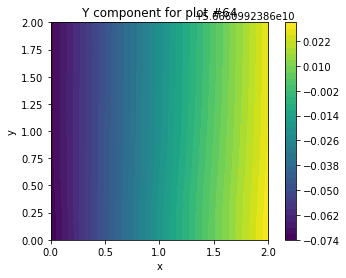

2.7206990463513265
solving at time step t=0.0951666
writing at t = 0.09663070659909186


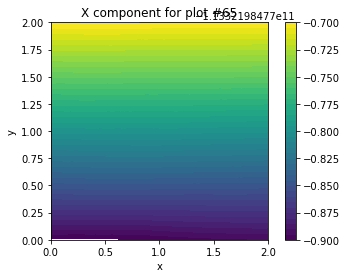

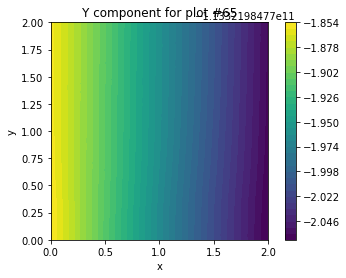

2.7206990463513265
solving at time step t=0.0966307
writing at t = 0.09809480821422961


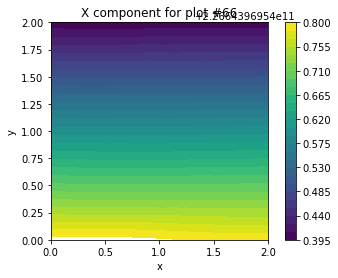

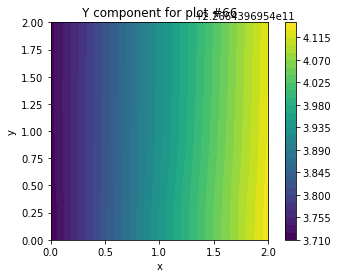

2.7206990463513265
solving at time step t=0.0980948
writing at t = 0.09955890982936737


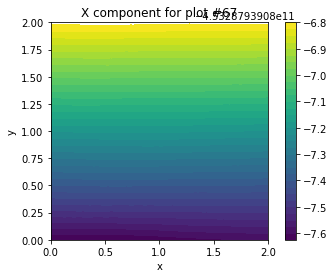

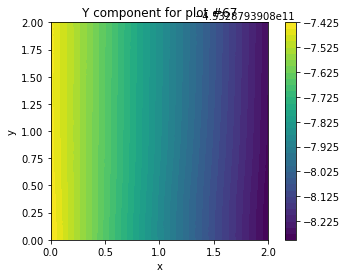

2.7206990463513265
solving at time step t=0.0995589
writing at t = 0.10102301144450512


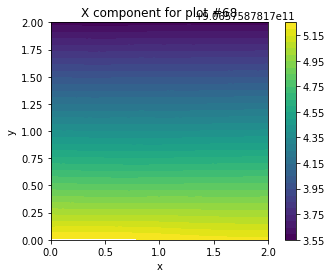

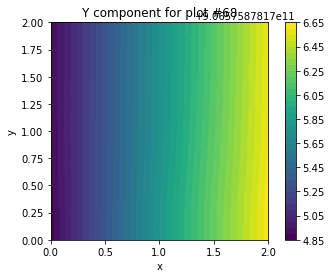

2.7206990463513265
solving at time step t=0.101023
writing at t = 0.10248711305964288


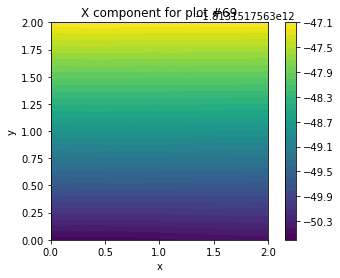

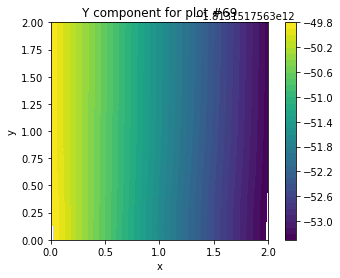

2.7206990463513265
solving at time step t=0.102487
writing at t = 0.10395121467478063


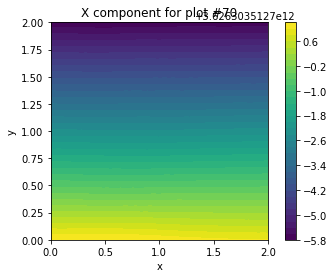

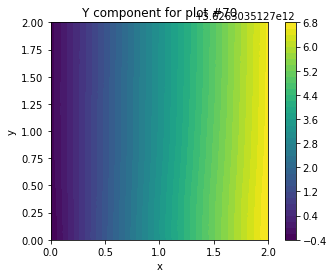

2.7206990463513265
solving at time step t=0.103951
writing at t = 0.10541531628991839


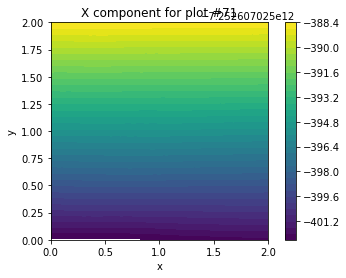

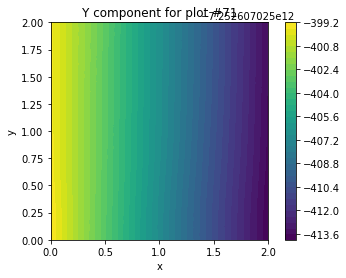

2.7206990463513265
solving at time step t=0.105415
writing at t = 0.10687941790505615


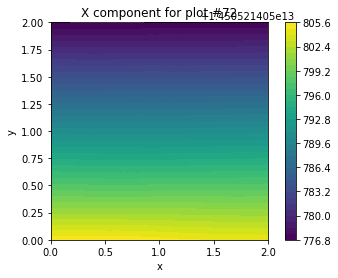

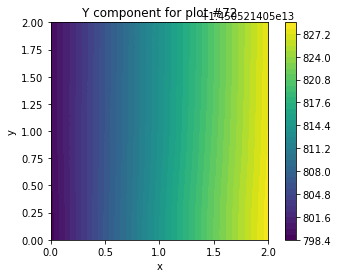

2.7206990463513265
solving at time step t=0.106879
writing at t = 0.1083435195201939


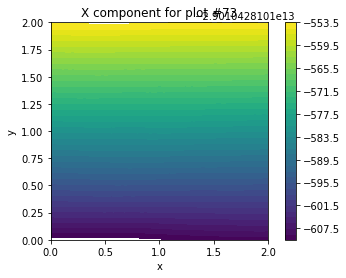

KeyboardInterrupt: 

In [11]:
from dolfin import *
import matplotlib.pyplot as plt
import matplotlib as m
import os
from ufl import nabla_div

# Constants
ys = 1
t = 0
T = 1
rho1 = 1.0
rho2 = 1.0
mu1 = 1.0
mu2 = 1.0
lamda1 = 1.0
lamda2 = 1.0

N = 50



# Mesh, functionspace, functions
L = 2.0
mesh = RectangleMesh(Point(0.0, 0.0), Point(L, L), N,N)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
S = FunctionSpace(mesh, V.ufl_element().family(), V.ufl_element().degree())    
zero_scalar = interpolate(Expression("0.0", degree=V.ufl_element().degree()), S)

D = VectorFunctionSpace(mesh, "DG", 0)
u = TrialFunction(V)
v = TestFunction(V)

v1         = sqrt((lamda1 + 2 * mu1) / rho1)
v2         = sqrt((lamda2 + 2 * mu2) / rho2)
v_cfl      = max(v1,v2)
dr         = (L / N) 
cfl_safety = 0.1
dt         = cfl_safety * dr / (1 + v_cfl)
print('UPDATE: dt = %s and dx = %s'%(dt, L/N))

# Define Subdomains
#cf = CellFunction("size_t", mesh, 0)
#domain1 = AutoSubDomain(lambda x: x[1] > ys)
#domain1.mark(cf,1)

# Define variable constants
#rhof = Expression(("x[1] > ys ? rho1 : rho2",
#                   "x[1] > ys ? rho1 : rho2"),
#                  ys=ys,rho1=rho1,rho2=rho2)
rhof   = Expression(("x[1] > ys? rho1 : rho2", "0.0"),
                  degree=0, ys=ys,rho1=rho1,rho2=rho2)
muf    = Expression(("x[1] > ys? mu1 : mu2", "0.0"),
                 degree=0, ys=ys,mu1=mu1,mu2=mu2)
lamdaf = Expression(("x[1] > ys? lamda1 : lamda2", "0.0"),
                    degree=0, ys=ys,lamda1=lamda1,lamda2=lamda2)
stepf  = Expression(("x[1] > ys? pow(dt,2)/rho1 : pow(dt,2)/rho2", "0.0"), 
                   degree=0, ys=ys,dt=dt,rho1=rho1,rho2=rho2)

#create the fields...note that we do this dot product trick because
# we have a vector-valued space
# TODO: Change this to a scalar-valued space...D does NOT need to be defined
#       as a vector field since it has nothing to do with the displacement vector

#NOTE: lamda is obviously mispelled, but that's because lambda is a keyword
#        of Python
e_x   = interpolate(Expression(('1.0', '0.0'), degree=1), D)
rho   = dot(e_x, interpolate(rhof, D))
mu    = dot(e_x, interpolate(muf, D))
lamda = dot(e_x, interpolate(lamdaf, D))
step  = dot(e_x, interpolate(stepf, D))


# Stress tensor
def sigma(u, lamda, mu):
    return lamda*nabla_div(u)*Identity(2) + mu*(grad(u) + grad(u).T)

mu1 = 1.0
mu2 = 1.0
sig = L / N / 2
alpha = 1 / sqrt(2 * pi * sig**2) 
gauss_expr = '%s * exp(-(pow(x[0] - %s, 2) + pow(x[1] - %s, 2)) / (2 * %s))'%(alpha,mu1,mu2,sig**2)
f = interpolate(Expression((gauss_expr, gauss_expr), degree=1), V)


# Initial conditions
#Ixy = Expression(('sin(3.14159 / 2 * x[0])*sin(3.14159 / 2 * x[1])', \
#                  'sin(3.14159 / 2 * x[0])*sin(3.14159 / 2 * x[1])'), degree=1)

k = pi / L
omega = k * sqrt((lamda1 + 2 * mu1) / rho1)
#Ixy = Expression(('cos(%s * x[0]) * cos(%s * x[1])'%(k,k), '0.0'), degree=1)
#Vxy = Expression(('cos(%s * x[0]) * cos(%s * x[1])'%(k,k), '0.0'), degree=1)
Ixy = Expression(('0.0', '0.0'), degree=1)
Vxy = Expression(('0.0', '0.0'), degree=1)
u1 = interpolate(Ixy, V)
u2 = interpolate(Vxy, V)

# Variational forms
#F = inner(u,v)*dx - 2*inner(u1,v)*dx + inner(u2,v)*dx + step * inner(sigma(u1,lamda,mu), grad(v)) * dx
A = rho * inner(u,v) * dx + inner(sigma(u,lamda,mu), grad(v)) * dx 


t = 2*dt
#left = assemble(lhs(F))
u = Function(V)

N = len(u.vector()[:])

def plot_comp(fnc, i, W, the_title, the_min, the_max):
    cdict = {
        'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
        'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
        'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
    }
    cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)
    cm = 'viridis'
    
    f = fnc
    if i == 0:
        e_x = interpolate(Expression(('1.0', '0.0'), degree=1), W)
        f = dot(fnc, e_x)
    elif i == 1:
        e_y = interpolate(Expression(('0.0', '1.0'), degree=1), W)
        f = dot(fnc, e_y)
    c = plot(f, cmap=cm)
    plt.colorbar(c)
    plt.title(the_title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
plot_comp(u1, 0, V, 'u_1 X component', -1,1)
plot_comp(u1, 1, V, 'u_1 Y component', -1, 1)
plot_comp(u2, 0, V, 'u_2 X component', -1,1)
plot_comp(u2, 1, V, 'u_2 Y component', -1, 1)
    
def get_comp(fnc, i, W):
    if( i == 0 ):
        return interpolate(dot(fnc, interpolate(Expression(('1.0', '0.0'), degree=1), W)), W)
    else:
        return interpolate(dot(fnc, interpolate(Expression(('0.0', '1.0'), degree=1), W)), W)
    
ofile = File('soln.pvd')
# Time stepping
i = 0
j = 1

def boundary(x, on_boundary):
    return on_boundary

k = pi / L

while t < T + DOLFIN_EPS:
    print('writing at t = %s'%(t))
    if( (i % 1) == 0 ):
        plot_comp(u,0,V, 'X component for plot #%s'%(j), -1.0, 1.0)
        plot_comp(u,1,V, 'Y component for plot #%s'%(j), -1.0, 1.0)
        j = j+1
    
    #right = assemble(rhs(F))
    print(omega)
    s1 = '0.0'
    s2 = '%s * (%s * sin(%s * x[0]) * sin(%s * x[1]) + %s * cos(%s * x[0]) * cos(%s * x[1]))'%\
         ((k**2) * cos(omega * t),lamda1,k,k,mu1,k,k)
    #f = interpolate(Expression((s1,s2), degree=1), V)
    L = Constant(1.0) * rho * 2 * inner(u2, v) * dx - Constant(1.0) * rho * inner(u1, v) * dx - \
        Constant(0.5 * dt**2) * inner(sigma(u2,lamda,mu), grad(v) + grad(v).T) * dx + \
        Constant(1.0 * dt**2) * inner(f, v) * dx
    
    print("solving at time step t=%g" % t)
    #bc = DirichletBC(V, Constant((0.0,0.0)), boundary)
    
    solve(A == L, u)
    #solve(left, u.vector(), right)
    t = t + dt
    i = i + 1

#    assign(u.sub(1), zero_scalar)
    
    u2.assign(u1)
    u1.assign(u)
    
os.system("sed -i \"\" \'s/UInt32/Int32/g\' *.vtu")
os.system("sed -i \"\" \'s/f_[0-9]*/f/g\' *.vtu")

In [3]:
#below is the code that is from the tutorial handbook for Fenics

from fenics import *
from ufl import nabla_div
# Scaled variables
L = 1
W = 0.2
mu = 1
rho = 1
delta = W/L
gamma = 0.4*delta**2 
beta = 1.25
lambda_ = beta 
g = gamma

# Create mesh and define function space
mesh = BoxMesh(Point(0, 0, 0), Point(L, W, W), 10, 3, 3)
V = VectorFunctionSpace(mesh, "P", 1)

# Define boundary condition
tol = 1E-14

def clamped_boundary(x, on_boundary):
    return on_boundary and x[0] < tol

bc = DirichletBC(V, Constant((0, 0, 0)), clamped_boundary) # Define strain and stress
def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T) #return sym(nabla_grad(u))

def sigma(u):
    return lambda_*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)

# Define variational problem
u = TrialFunction(V)
d = u.geometric_dimension() # space dimension 
v = TestFunction(V)
f = Constant((0, 0, -rho*g))
T = Constant((0, 0, 0))
a = inner(sigma(u), epsilon(v))*dx
L = dot(f, v)*dx + dot(T, v)*ds
# Compute solution
u = Function(V)
solve(a == L, u, bc)
# Plot solution
vtkfile = File("soln.pvd") 
vtkfile << u

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(0,1,1000)
y = np.linspace(0,1,1000)
X,Y = np.meshgrid(x,y)

Z = np.sqrt(X ** 2 + Y ** 2)

plt.plot(X,Y,Z)

In [ ]:
W = VectorFunctionSpace(mesh, "Lagrange", 1)
f = interpolate(Expression(('sin(x[0])', 'exp(-x[1])'), degree=1), W)
e_x = interpolate(Expression(('1.0', '0.0'), degree=1), W)
e_y = interpolate(Expression(('0.0', '1.0'), degree=1), W)

c = plot(dot(f,e_x), mode='color')
plt.colorbar(c)
plt.title("X component of test field")
plt.show()

c = plot(dot(f,e_y))
plt.colorbar(c)
plt.title('Y component of test field')
plt.show()

c = plot(f)
plt.colorbar(c)
plt.title('Full test vector field')

In [ ]:
print("sed -i \"\" \'s/UInt32/Int32/g\' *.vtu")

In [ ]:
print("sed -i \"\" \'s/f_[0-9]*/f/g\' *.vtu")

In [ ]:
max(1,2)

In [4]:
np.pi

NameError: name 'np' is not defined

In [5]:
DOLFIN.PI

NameError: name 'DOLFIN' is not defined

In [6]:
math.pi

NameError: name 'math' is not defined

In [7]:
pi

3.141592653589793

In [8]:
sqrt(pi)

1.7724538509055159

In [9]:
exp(1)

2.718281828459045

In [22]:
cos(1)

0.5403023058681398

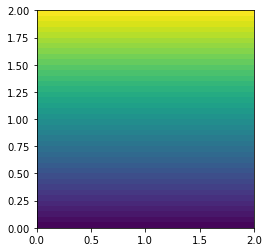

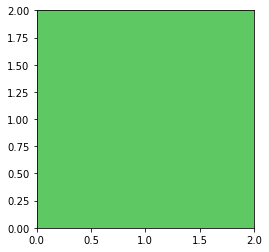

In [16]:
g = interpolate(Expression(('x[0]', 'x[1]'), degree=1), V)
plot(g.sub(1))
plt.show()

S = FunctionSpace(mesh, V.ufl_element().family(), V.ufl_element().degree())    
u0 = interpolate(Expression("0.0", degree=V.ufl_element().degree()), S)
assign(g.sub(1), u0)
plot(g.sub(1))
plt.show()